In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math


In [27]:
def make_signal(w,theta,m):
    """
    Assumes normalized amplitude
    """
    t = np.arange(m)
    signal = np.exp(1j*(w*t + theta))
    return signal

def make_noise(sigma2,m):
    noise_scaling = np.sqrt(sigma2/2)
    # noise is complex valued
    noise  = noise_scaling*np.random.randn(m) + 1j*noise_scaling*np.random.randn(m)
    return noise

def make_noisy_signal(w,theta,SNRdb,m):
    sigma2 = get_sigma2_from_snrdb(SNRdb)
    signal = make_signal(w,theta,m)
    noise  = make_noise(sigma2,m)
    return signal + noise

# N = divisor of w0
# m = num samples
def make_batch_noisy(batch_size, SNRdb, N, m, binary=False):
    signals, freqs = [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        w = (2 * np.pi * freq / N) % (2 * np.pi)
        sig = make_noisy_signal(w, 0, SNRdb, m)
        signals.append(sig)
        freqs.append(freq)
    if binary:
        return signals, make_binary(freqs, N), one_hot(N, batch_size, freqs)
    return signals, one_hot(N, batch_size, freqs)

# N = divisor of w0
# m = num samples
# starts = shift for each subsequent sample
def make_batch_noisy_lohi(batch_size, SNRdb, N, m, inds, starts=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]):
    freqs = []
    randoms = []
    freqs.append(np.random.randint(0, N))
    test_signals, test_freqs, test_rand = make_noisy_lohi(SNRdB, N, m, freqs[-1], inds, starts)
    randoms.append(test_rand)
    for i in range(1, batch_size):
        freqs.append(np.random.randint(0, N))
        a, b, c = make_noisy_lohi(SNRdB, N, m, freqs[-1], inds, starts)
        test_signals.extend(a)
        test_freqs.extend(b)
        randoms.append(c)
    return test_signals, test_freqs, freqs, randoms

# inds=random indices used to test mle
def make_noisy_lohi(SNRdb, N, m, freq, inds, starts):
    signals, vals = [], []
    steps = int(np.log2(N))
    w = (2 * np.pi * freq / N) % (2 * np.pi)
    sig = make_noisy_signal(w, 0, SNRdb, N)
    #start = 0
    for i in range(int(np.log2(N))):
        #start = start + np.random.randint(N // 4) if i > 0 else 0
        signals.append([sig[(starts[i] + a * (2**i)) % N] for a in range(m)])
        if (freq * (2**i)) % (N) < N / 2:
            vals.append([0])
        else:
            vals.append([1])
    return signals, vals, np.take(sig, inds)
        

def make_batch_singleton(batch_size, SNRdb, N, m, default=-1): # 0 = zero, 1 = single, 2 = multi
    signals, freqs = [], []
    sigma2 = get_sigma2_from_snrdb(SNRdB)
    for i in range(batch_size):
        val = np.random.poisson(0.79)
        if default >= 0:
            val = default
        if val == 0:
            signals.append(make_noise(0, m))
            freqs.append([1, 0, 0])
        if val == 1:
            signals.append(make_noisy_signal(2 * np.pi * np.random.randint(0, N) / N, 0, SNRdB, m))
            freqs.append([0, 1, 0])
        if val >= 2:
            signal = make_signal(2 * np.pi * np.random.randint(0, N) / N, 0, m)
            for i in range(val - 1):
                signal += make_signal(2 * np.pi * np.random.randint(0, N) / N, 0, m)
            signals.append(signal + make_noise(sigma2, m))
            freqs.append([0, 0, 1])
    return signals, freqs

def make_batch_parity(signals, freqs):
    bits = [[(np.binary_repr(f, width=14).count('1') % 2)] for f in freqs]
    #bits = [[(int(np.binary_repr(f, width=14)[0]) % 2)] for f in freqs]
    return (signals, bits)

def get_sigma2_from_snrdb(SNR_db):
    return 10**(-SNR_db/10)

def kay_weights(N):
    scaling = (3.0/2)*N/(N**2 - 1)
    
    w = [1 - ((i - (N/2 - 1))/(N/2))**2 for i in range(N-1)]
    
    return scaling*np.array(w)

def kays_method(my_signal):
    N = len(my_signal)
    w = kay_weights(N)
    
    angle_diff = np.angle(np.conj(my_signal[0:-1])*my_signal[1:])
    need_to_shift = np.any(angle_diff < -np.pi/2)
    if need_to_shift:    
        neg_idx = angle_diff < 0
        angle_diff[neg_idx] += np.pi*2
    
    return w.dot(angle_diff)

def kays_singleton_accuracy(test_signals, test_freqs, N):
    diffs = [s - make_signal(kays_method(s), 0, N) for s in test_signals]
    thresh, single_acc, other_acc, best_thresh = 0.0, 0, 0, 0
    best = 0
    for i in range(150):
        vals = [(sum(np.absolute(s)) / N) < thresh for s in diffs]
        corr = [1 for i in range(len(test_freqs)) if (test_freqs[i] == [0, 1, 0] and vals[i] == 1) or ((test_freqs[i] != [0, 1, 0] and vals[i] == 0))]
        corr = sum(corr)
        #single = sum([vals[d] for d in range(len(vals)) if test_freqs[d] == [0, 1, 0]]) / len([vals[d] for d in range(len(vals)) if test_freqs[d] == [0, 1, 0]])
        #other = sum([not vals[d] for d in range(len(vals)) if test_freqs[d] != [0, 1, 0]]) / len([vals[d] for d in range(len(vals)) if test_freqs[d] != [0, 1, 0]])        
        #if single*2 + other > single_acc*2 + other_acc and single > 0.2 and other > 0.2:
        #    single_acc = single
        #    other_acc = other
        #    best_thresh = thresh
        if corr > best:
            best = corr
            best_thresh = thresh
        thresh += 0.05
    print('thresh: ', best_thresh)
    return best / len(test_signals)

def test_kays(signals, freqs, N):
    count = 0
    for sig, freq in zip(signals, freqs):
        res = kays_method(sig)
        res = round(res * N / (2 * np.pi))
        if np.argmax(freq) == res:
            count += 1
    return count / len(signals)

def test_mle(signals, freqs, N, m):
    count = 0
    for sig, freq in zip(signals, freqs):
        cleans = [make_signal(np.pi * 2 * w / N, 0, m) for w in range(N)]
        dots = [np.absolute(np.vdot(sig, clean)) for clean in cleans]
        if np.argmax(dots) == np.argmax(freq):
            count += 1
    return count / len(signals)
    
def make_binary(freqs, N):
    w = math.ceil(np.log2(N))
    return [[int(a) for a in list(np.binary_repr(f, width=w))] for f in freqs] 

def binary_to_int(binary_string):
    return tf.reduce_sum(
    tf.cast(tf.reverse(tensor=binary_string, axis=[0]), dtype=tf.int64)
    * 2 ** tf.range(tf.cast(tf.size(binary_string), dtype=tf.int64)))
    '''y = 0
    for i,j in enumerate(x):
        y += j<<i
    return y'''

def hamming(pred, act):
    return np.count_nonzero(pred != act)

def one_hot(N, batch_size, freqs):
    freqs_one_hot = np.zeros((batch_size, N))
    freqs_one_hot[np.arange(batch_size), freqs] = 1
    return freqs_one_hot

def test_noisy_mle(N, m, signals, freqs):
    count = 0  
    '''imag_signals = []
    for index in range(len(signals)):
        sig = signals[index]
        imag_sig = [(sig[i] + 1j*sig[i+1]) for i in np.arange(len(sig), step=2)]
        imag_signals.append(imag_sig)'''
    cleans = [make_signal(2*np.pi*i/N, 0, m) for i in range(N)]
                     
    for index in range(len(signals)):
        dots = [np.absolute(np.vdot(signals[index], cleans[i])) for i in range(N)]
        if np.argmax(freqs[index]) == np.argmax(dots):
            #print(np.argmax(dots))
            count += 1
    return count / len(freqs)

def bit_to_freq(bits, N):
    possible = [i for i in range(N)]
    for b in bits:
        if not b[0]:
            possible = possible[:len(possible)//2]
        else:
            possible = possible[len(possible)//2:]
    return possible[0]

def convert_bits(bits):
    val = 0
    for i in range(len(bits)):
        val += bits[len(bits) - 1 - i] * (2**i)
    return val

def make_signal_random(w,theta, N, m, inds):
    sig = make_signal(w, theta, N)
    #chosen_indices = np.sort(np.random.choice(range(N), size=m, replace=False))
    return np.take(sig, inds)

def test_all_1bit(bits, N, m, signal):
    vals = []
    new_signal = np.zeros((m))
    new_signal = signal[:, 0] + 1j*signal[:, 1]
    signal = new_signal
    min_ind = convert_bits(bits)
    sig = make_signal((convert_bits(bits) * 2*np.pi/N), 0, m)
    min_val = np.vdot(sig - signal, sig - signal)
    vals.append(min_val)
    for i in range((len(bits) // 2)): # because less significant bits have more wiggle - easier to cause false error
        bits[i] = abs(bits[i] - 1)
        sig = make_signal((convert_bits(bits) * 2*np.pi/N), 0, m)
        resid = np.vdot(sig - signal, sig - signal)
        vals.append(resid)
        if resid < min_val: 
            min_val = resid
            min_ind = convert_bits(bits)
        bits[i] = abs(bits[i] - 1)
    #print('thresh: ', min_ind)
    #print(vals)
    #print(min_ind == convert_bits(bits))
    return min_ind

def test_all_1bit_random(bits, N, m, signal, inds): # try set of all combined measurements mle
    vals = []
    #new_signal = np.zeros((m))
    #new_signal = signal[:, 0] + 1j*signal[:, 1]
    #signal = new_signal
    min_ind = convert_bits(bits)
    sig = make_signal_random((convert_bits(bits) * 2*np.pi/N), 0, N, m, inds)
    min_val = np.vdot(sig - signal, sig - signal)
    vals.append(min_val)
    for i in range((len(bits))): # because less significant bits have more wiggle - easier to cause false error
        bits[i] = abs(bits[i] - 1)
        sig = make_signal_random((convert_bits(bits) * 2*np.pi/N), 0, N, m, inds)
        resid = np.vdot(sig - signal, sig - signal)
        vals.append(resid)
        if resid < min_val: 
            min_val = resid
            min_ind = convert_bits(bits)
        bits[i] = abs(bits[i] - 1)
    #print('thresh: ', min_ind)
    #print(vals)
    #print(min_ind == convert_bits(bits))
    return min_ind

In [33]:
# div and conquer freq detect

N = 16384 
layer = 2  #6
layer2 = 5
m = 30
TRIALS = 10 #15
TEST_BATCHES = 75

log = int(np.log2(N))

# Parameters
learning_rate = 0.005
num_iter = 17500 #80000
batch_size = log * 20
batch_size2 = 20



# Network Parameters
num_classes = 1

snrs = [10, 8, 6, 4, 2, 0, -2]
#snrs = [4, 2, 0, -2]

bin_accs = []
freq_accs = []
freq_accs2 = []
all_preds = []
all_actuals = []

#starts = [0]
#for i in range(1, log): # filling all the starting points
#    starts.append(starts[i-1] + np.random.randint(N // 4))

starts = [0] * 15 # if starting at 0 every resample
indices = np.sort(np.random.choice(range(N), size=m, replace=False))

for SNRdB in snrs:
    print('SNR:', SNRdB)

    t_bins = []
    t_freqs = []
    t_freqs2 = []
    t_preds = []
    t_actuals = []
    
    training_size = 4999 #5999
    dict = {}
    dict2 = {}
    for i in range(training_size):
        if i % 500 == 0:
            print('gen training batch:', i)
        batch_x, batch_y, batch_freqs, batch_rands = make_batch_noisy_lohi(batch_size // log, SNRdB - 2, N, m, indices, starts) # i % 3
        batch_x_pair = np.zeros((batch_size, m, 2))
        batch_x_pair[:, :, 0] = np.real(batch_x)
        batch_x_pair[:, :, 1] = np.imag(batch_x)
        dict[i] = (batch_x_pair, batch_y, batch_rands)
        #dict2[i] = make_batch_parity([batch_x_pair[j] for j in range(0, len(batch_x_pair), log)], batch_freqs)
    
    for trial in range(TRIALS):
        print('TRIAL:', trial)
        # tf Graph input
        X = tf.placeholder("float", [None, m, 2])
        Y = tf.placeholder("float", [None, num_classes])
        Y2 = tf.placeholder("float", [None, num_classes])

        # weights for frequency classification
        weights = {i: tf.Variable(tf.random_normal([3, 2, 2])) for i in range(1, layer+1)} # increase out channels, less layers
        weights[0] = tf.Variable(tf.random_normal([5, 2, 2]))
        weights['out'] = tf.Variable(tf.random_normal([(m-4-(2*layer))*2, num_classes]))
        biases = {i: tf.Variable(tf.random_normal([2])) for i in range(layer+1)}
        biases['out'] = tf.Variable(tf.random_normal([num_classes]))


        def neural_net(x):
            layer_1 = tf.add(tf.nn.conv1d(x, weights[0], 1, 'VALID'), biases[0])
            hidden_1 = tf.nn.relu(layer_1)
            for i in range(1, layer+1):
                layer_1 = tf.add(tf.nn.conv1d(hidden_1, weights[i], 1, 'VALID'), biases[i]) # no padding
                hidden_1 = tf.nn.relu(layer_1) # try: elu, leaky
                ###hidden_1 = tf.layers.batch_normalization(hidden_1)
                ### instance normalize
            hidden_3 = tf.reshape(hidden_1, [batch_size, -1])
            out_layer = tf.matmul(hidden_3, weights['out']) + biases['out']
            return out_layer
        
        # weights for parity network
        weights2 = {i: tf.Variable(tf.random_normal([3, 2, 2])) for i in range(1, layer2+1)} # increase out channels, less layers
        weights2[0] = tf.Variable(tf.random_normal([5, 2, 2]))
        weights2['out'] = tf.Variable(tf.random_normal([(m-4-(2*layer2))*2, num_classes]))
        biases2 = {i: tf.Variable(tf.random_normal([2])) for i in range(layer2+1)}
        biases2['out'] = tf.Variable(tf.random_normal([num_classes]))


        def neural_net2(x):
            layer_1 = tf.add(tf.nn.conv1d(x, weights2[0], 1, 'VALID'), biases2[0])
            hidden_1 = tf.nn.relu(layer_1)
            for i in range(1, layer2+1):
                layer_1 = tf.add(tf.nn.conv1d(hidden_1, weights2[i], 1, 'VALID'), biases2[i]) # no padding
                hidden_1 = tf.nn.relu(layer_1) # try: elu, leaky
                ###hidden_1 = tf.layers.batch_normalization(hidden_1)
                ### instance normalize
            hidden_3 = tf.reshape(hidden_1, [batch_size2, -1])
            out_layer = tf.matmul(hidden_3, weights2['out']) + biases2['out']
            return out_layer


        test_dict = {}
        test_dict2 = {}
        for i in range(TEST_BATCHES):
            test_signals, test_freqs, freqs, test_rands = make_batch_noisy_lohi(batch_size // log, SNRdB, N, m, indices, starts)
            test_signals_pair = np.zeros((batch_size, m, 2))
            test_signals_pair[:, :, 0] = np.real(test_signals)
            test_signals_pair[:, :, 1] = np.imag(test_signals)
            test_dict[i] = (test_signals_pair, test_freqs, freqs, test_rands)
            #test_dict2[i] = make_batch_parity([test_signals_pair[j] for j in range(0, len(test_signals_pair), log)], freqs)



        # Construct model
        logits = neural_net(X)
        prediction = tf.nn.sigmoid(logits)
        losses, accuracies = [], []

        # Define loss and optimizer
        loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=Y))  

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op)

        # Evaluate model
        pred_class = tf.greater(prediction, 0.5)
        correct_pred = tf.equal(pred_class, tf.equal(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        # Construct model (parity)
        logits2 = neural_net2(X)
        prediction2 = tf.nn.sigmoid(logits2)
        losses2, accuracies2 = [], []

        # Define loss and optimizer
        loss_op2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits2, labels=Y2))  

        optimizer2 = tf.train.AdamOptimizer(learning_rate=0.00005)
        train_op2 = optimizer2.minimize(loss_op2)

        # Evaluate model
        pred_class2 = tf.greater(prediction2, 0.5)
        correct_pred2 = tf.equal(pred_class2, tf.equal(Y2, 1))
        accuracy2 = tf.reduce_mean(tf.cast(correct_pred2, tf.float32))

        # Initialize the variables (i.e. assign their default value)
        init = tf.global_variables_initializer()

        # Start training
        with tf.Session() as sess:

            # Run the initializer
            sess.run(init)
            print("Training Started")

            for step in range(1, num_iter + 1):
                batch_x_pair, batch_y, rands = dict[step % training_size]
                #batch_x_pair2, batch_y2 = dict2[step % training_size]

                # Run optimization op (backprop)
                sess.run(train_op, feed_dict={X: batch_x_pair, Y: batch_y})
                #sess.run(train_op2, feed_dict={X: batch_x_pair2, Y2: batch_y2})
                
                if step % 500 == 0:
                    # Calculate batch loss and accuracy
                    loss, acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: batch_x_pair,
                                                                         Y: batch_y})
                    #loss2, acc2, pred2 = sess.run([loss_op2, accuracy2, prediction2], feed_dict={X: batch_x_pair2,
                    #                                                     Y2: batch_y2})

                    accuracies.append(acc)
                    losses.append(loss)
                    print("Freq Iter " + str(step) + ", Minibatch Loss= " + \
                          "{:.4f}".format(loss) + ", Training Accuracy= " + \
                          "{:.3f}".format(acc))
                    #print("Pari Iter " + str(step) + ", Minibatch Loss= " + \
                    #      "{:.4f}".format(loss2) + ", Training Accuracy= " + \
                    #      "{:.3f}".format(acc2))
                    #print(pred2)
                    #print(batch_y2)
            print("Training Finished")
            preds = [sess.run(prediction, feed_dict={X: test_dict[i][0], Y: test_dict[i][1]}) for i in range(len(test_dict))]  
            nn_acc = [sess.run(accuracy, feed_dict={X: test_dict[i][0], Y: test_dict[i][1]}) for i in range(len(test_dict))]   
            print(nn_acc)
        t_preds.append(preds)
        t_actuals.append([test_dict[i][1] for i in range(len(test_dict))])

        t_bins.append(np.median(nn_acc))
        preds = np.round(preds)
        corr = []
        corr2 = []
        for a in range(len(test_dict)):
            fs = []
            fs2 = []
            for k in range(len(preds[a]) // log):
                    ##fs2.append(bit_to_freq(preds[a][k * log : (k+1) * log], N))
                    fs2.append(convert_bits(preds[a][k * log : (k+1) * log]))
                    #fs2.append(test_all_1bit(preds[a][k * log : (k+1) * log], N, m, test_dict[a][0][k * log]))
                    fs.append(test_all_1bit_random(preds[a][k * log : (k+1) * log], N, m, test_dict[a][3][k], indices))
            corr.extend([fs[i] == test_dict[a][2][i] % N for i in range(len(fs))])
            corr2.extend([fs2[i] == test_dict[a][2][i] % N for i in range(len(fs2))])
        t_freqs.append(np.sum(corr) / (len(fs) * len(test_dict)))
        t_freqs2.append(np.sum(corr2) / (len(fs) * len(test_dict)))
        print('random:', t_freqs[-1])
        print('single:', np.sum(corr2) / (len(fs2) * len(test_dict)))
        
    bin_accs.append(max(t_bins))
    freq_accs.append(max(t_freqs))
    freq_accs2.append(max(t_freqs2))
    all_preds.append(t_preds[np.argmax(t_freqs)])
    all_actuals.append(t_actuals[np.argmax(t_freqs)])
    print('best bin classifier acc:', bin_accs[-1])
    print('best freq detection acc:', freq_accs[-1])
    print('best freq2 detection acc:', freq_accs2[-1])
    
np.save('./data/freq_new_network/snrs_update', snrs)   
np.save('./data/freq_new_network/acc_binary_2layer_random', bin_accs)
np.save('./data/freq_new_network/acc_frequency_2layer_random', freq_accs)
np.save('./data/freq_new_network/acc_frequency_2layer_single', freq_accs2)
##np.save('./data/freq_new_network/preds_frequency', all_preds)
##np.save('./data/freq_new_network/actuals_frequency', all_actuals)




SNR: 10
gen training batch: 0
gen training batch: 500
gen training batch: 1000
gen training batch: 1500
gen training batch: 2000
gen training batch: 2500
gen training batch: 3000
gen training batch: 3500
gen training batch: 4000
gen training batch: 4500
TRIAL: 0
Training Started
Freq Iter 500, Minibatch Loss= 0.4969, Training Accuracy= 0.739
Freq Iter 1000, Minibatch Loss= 0.1267, Training Accuracy= 0.975
Freq Iter 1500, Minibatch Loss= 0.0306, Training Accuracy= 0.996
Freq Iter 2000, Minibatch Loss= 0.0128, Training Accuracy= 1.000
Freq Iter 2500, Minibatch Loss= 0.1285, Training Accuracy= 0.968
Freq Iter 3000, Minibatch Loss= 0.0175, Training Accuracy= 0.996
Freq Iter 3500, Minibatch Loss= 0.0146, Training Accuracy= 0.996
Freq Iter 4000, Minibatch Loss= 0.0121, Training Accuracy= 0.996
Freq Iter 4500, Minibatch Loss= 0.0048, Training Accuracy= 1.000
Freq Iter 5000, Minibatch Loss= 0.0211, Training Accuracy= 0.989
Freq Iter 5500, Minibatch Loss= 0.0034, Training Accuracy= 1.000
Freq I

Freq Iter 14500, Minibatch Loss= 0.0009, Training Accuracy= 1.000
Freq Iter 15000, Minibatch Loss= 0.0020, Training Accuracy= 1.000
Freq Iter 15500, Minibatch Loss= 0.0013, Training Accuracy= 1.000
Freq Iter 16000, Minibatch Loss= 0.0015, Training Accuracy= 1.000
Freq Iter 16500, Minibatch Loss= 0.0153, Training Accuracy= 0.996
Freq Iter 17000, Minibatch Loss= 0.0011, Training Accuracy= 1.000
Freq Iter 17500, Minibatch Loss= 0.0116, Training Accuracy= 0.996
Training Finished
[0.9928571, 1.0, 1.0, 0.98928565, 0.98928565, 1.0, 1.0, 0.99642855, 1.0, 0.99642855, 0.98928565, 1.0, 0.99642855, 0.99285716, 0.99642855, 1.0, 0.99642855, 1.0, 1.0, 0.9892857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99642855, 1.0, 1.0, 1.0, 0.9892857, 1.0, 0.99642855, 0.99642855, 1.0, 0.99642855, 0.99285716, 1.0, 0.9964286, 1.0, 1.0, 0.99642855, 1.0, 1.0, 1.0, 0.99642855, 0.99285716, 1.0, 1.0, 1.0, 0.99642855, 1.0, 1.0, 1.0, 1.0, 0.9928571, 1.0, 0.99285716, 0.9928571, 1.0, 0.99642855, 0.99285716, 1.0, 1.0, 1.0, 1.0, 0

Freq Iter 9000, Minibatch Loss= 0.0101, Training Accuracy= 0.996
Freq Iter 9500, Minibatch Loss= 0.0032, Training Accuracy= 1.000
Freq Iter 10000, Minibatch Loss= 0.0031, Training Accuracy= 1.000
Freq Iter 10500, Minibatch Loss= 0.0010, Training Accuracy= 1.000
Freq Iter 11000, Minibatch Loss= 0.0131, Training Accuracy= 0.996
Freq Iter 11500, Minibatch Loss= 0.0033, Training Accuracy= 1.000
Freq Iter 12000, Minibatch Loss= 0.0020, Training Accuracy= 1.000
Freq Iter 12500, Minibatch Loss= 0.0092, Training Accuracy= 0.993
Freq Iter 13000, Minibatch Loss= 0.0025, Training Accuracy= 1.000
Freq Iter 13500, Minibatch Loss= 0.0306, Training Accuracy= 0.989
Freq Iter 14000, Minibatch Loss= 0.0022, Training Accuracy= 1.000
Freq Iter 14500, Minibatch Loss= 0.0019, Training Accuracy= 1.000
Freq Iter 15000, Minibatch Loss= 0.0024, Training Accuracy= 1.000
Freq Iter 15500, Minibatch Loss= 0.0138, Training Accuracy= 0.996
Freq Iter 16000, Minibatch Loss= 0.0031, Training Accuracy= 1.000
Freq Iter 16

Freq Iter 3000, Minibatch Loss= 0.0241, Training Accuracy= 0.989
Freq Iter 3500, Minibatch Loss= 0.0121, Training Accuracy= 0.996
Freq Iter 4000, Minibatch Loss= 0.0093, Training Accuracy= 0.996
Freq Iter 4500, Minibatch Loss= 0.0096, Training Accuracy= 0.996
Freq Iter 5000, Minibatch Loss= 0.0349, Training Accuracy= 0.989
Freq Iter 5500, Minibatch Loss= 0.0024, Training Accuracy= 1.000
Freq Iter 6000, Minibatch Loss= 0.0131, Training Accuracy= 0.993
Freq Iter 6500, Minibatch Loss= 0.0137, Training Accuracy= 0.996
Freq Iter 7000, Minibatch Loss= 0.0062, Training Accuracy= 1.000
Freq Iter 7500, Minibatch Loss= 0.0301, Training Accuracy= 0.989
Freq Iter 8000, Minibatch Loss= 0.0039, Training Accuracy= 1.000
Freq Iter 8500, Minibatch Loss= 0.0031, Training Accuracy= 1.000
Freq Iter 9000, Minibatch Loss= 0.0062, Training Accuracy= 1.000
Freq Iter 9500, Minibatch Loss= 0.0236, Training Accuracy= 0.996
Freq Iter 10000, Minibatch Loss= 0.0034, Training Accuracy= 1.000
Freq Iter 10500, Minibat

Freq Iter 16500, Minibatch Loss= 0.0142, Training Accuracy= 0.993
Freq Iter 17000, Minibatch Loss= 0.0094, Training Accuracy= 0.993
Freq Iter 17500, Minibatch Loss= 0.0043, Training Accuracy= 1.000
Training Finished
[0.99285716, 0.9928571, 0.99642855, 1.0, 0.9785714, 1.0, 0.9928571, 0.99285716, 1.0, 0.9892857, 0.99642855, 0.99642855, 0.9964286, 1.0, 0.99285716, 1.0, 0.99642855, 1.0, 1.0, 1.0, 0.9678571, 1.0, 1.0, 0.9857143, 1.0, 1.0, 0.99642855, 1.0, 1.0, 0.9892857, 1.0, 0.99285716, 1.0, 1.0, 0.99642855, 0.9928571, 0.99642855, 1.0, 0.9964286, 1.0, 1.0, 0.99642855, 1.0, 1.0, 0.99642855, 1.0, 0.99285716, 1.0, 0.9892857, 1.0, 0.9964286, 1.0, 1.0, 1.0, 0.99642855, 0.99642855, 1.0, 0.99285716, 0.9964286, 0.99642855, 0.99642855, 0.97857136, 1.0, 0.99285716, 1.0, 0.99642855, 0.9964286, 1.0, 0.98571426, 1.0, 0.99642855, 1.0, 0.99642855, 1.0, 0.9928571]
random: 0.9866666666666667
single: 0.964
TRIAL: 1
Training Started
Freq Iter 500, Minibatch Loss= 0.2338, Training Accuracy= 0.939
Freq Iter 10

Freq Iter 9500, Minibatch Loss= 0.0064, Training Accuracy= 1.000
Freq Iter 10000, Minibatch Loss= 0.0238, Training Accuracy= 0.993
Freq Iter 10500, Minibatch Loss= 0.0469, Training Accuracy= 0.979
Freq Iter 11000, Minibatch Loss= 0.0097, Training Accuracy= 1.000
Freq Iter 11500, Minibatch Loss= 0.0050, Training Accuracy= 1.000
Freq Iter 12000, Minibatch Loss= 0.0063, Training Accuracy= 1.000
Freq Iter 12500, Minibatch Loss= 0.0122, Training Accuracy= 0.996
Freq Iter 13000, Minibatch Loss= 0.0346, Training Accuracy= 0.989
Freq Iter 13500, Minibatch Loss= 0.0418, Training Accuracy= 0.986
Freq Iter 14000, Minibatch Loss= 0.0255, Training Accuracy= 0.989
Freq Iter 14500, Minibatch Loss= 0.0115, Training Accuracy= 0.993
Freq Iter 15000, Minibatch Loss= 0.0055, Training Accuracy= 1.000
Freq Iter 15500, Minibatch Loss= 0.0086, Training Accuracy= 0.996
Freq Iter 16000, Minibatch Loss= 0.0271, Training Accuracy= 0.996
Freq Iter 16500, Minibatch Loss= 0.0213, Training Accuracy= 0.989
Freq Iter 1

Freq Iter 1000, Minibatch Loss= 0.5912, Training Accuracy= 0.664
Freq Iter 1500, Minibatch Loss= 0.1275, Training Accuracy= 0.979
Freq Iter 2000, Minibatch Loss= 0.0692, Training Accuracy= 0.986
Freq Iter 2500, Minibatch Loss= 0.0425, Training Accuracy= 0.993
Freq Iter 3000, Minibatch Loss= 0.0545, Training Accuracy= 0.989
Freq Iter 3500, Minibatch Loss= 0.0614, Training Accuracy= 0.986
Freq Iter 4000, Minibatch Loss= 0.0264, Training Accuracy= 0.996
Freq Iter 4500, Minibatch Loss= 0.0920, Training Accuracy= 0.979
Freq Iter 5000, Minibatch Loss= 0.0516, Training Accuracy= 0.986
Freq Iter 5500, Minibatch Loss= 0.0115, Training Accuracy= 0.996
Freq Iter 6000, Minibatch Loss= 0.0220, Training Accuracy= 0.996
Freq Iter 6500, Minibatch Loss= 0.0305, Training Accuracy= 0.993
Freq Iter 7000, Minibatch Loss= 0.0376, Training Accuracy= 0.993
Freq Iter 7500, Minibatch Loss= 0.0093, Training Accuracy= 1.000
Freq Iter 8000, Minibatch Loss= 0.0369, Training Accuracy= 0.989
Freq Iter 8500, Minibatch

Freq Iter 16500, Minibatch Loss= 0.0143, Training Accuracy= 0.996
Freq Iter 17000, Minibatch Loss= 0.0172, Training Accuracy= 0.993
Freq Iter 17500, Minibatch Loss= 0.0067, Training Accuracy= 0.996
Training Finished
[0.9928571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99285716, 1.0, 0.99285716, 1.0, 0.99642855, 1.0, 1.0, 0.99642855, 1.0, 0.99642855, 1.0, 0.9928571, 0.99642855, 0.9857143, 1.0, 1.0, 0.99642855, 0.9857143, 0.98928565, 0.9785714, 1.0, 0.99285716, 0.98928565, 1.0, 0.99642855, 1.0, 0.9964286, 0.99642855, 1.0, 1.0, 0.9928571, 1.0, 1.0, 0.99642855, 0.9964286, 1.0, 1.0, 1.0, 0.9928571, 1.0, 0.98571426, 0.9928571, 1.0, 1.0, 1.0, 0.9928571, 1.0, 0.9928571, 0.9928571, 0.9857143, 0.98928565, 1.0, 0.9964286, 0.99642855, 1.0, 0.98928577, 1.0, 1.0, 0.99642855, 0.99642855, 1.0, 1.0, 1.0, 0.9892857, 1.0, 1.0, 1.0, 0.9892857, 0.9964286]
random: 0.988
single: 0.966
TRIAL: 9
Training Started
Freq Iter 500, Minibatch Loss= 0.3436, Training Accuracy= 0.871
Freq Iter 1000, Minibatch Loss= 0.0779, Training 

Freq Iter 7000, Minibatch Loss= 0.0194, Training Accuracy= 0.996
Freq Iter 7500, Minibatch Loss= 0.0285, Training Accuracy= 0.986
Freq Iter 8000, Minibatch Loss= 0.0557, Training Accuracy= 0.982
Freq Iter 8500, Minibatch Loss= 0.0079, Training Accuracy= 1.000
Freq Iter 9000, Minibatch Loss= 0.0262, Training Accuracy= 0.993
Freq Iter 9500, Minibatch Loss= 0.0394, Training Accuracy= 0.993
Freq Iter 10000, Minibatch Loss= 0.0105, Training Accuracy= 1.000
Freq Iter 10500, Minibatch Loss= 0.0234, Training Accuracy= 0.989
Freq Iter 11000, Minibatch Loss= 0.0260, Training Accuracy= 0.993
Freq Iter 11500, Minibatch Loss= 0.0092, Training Accuracy= 0.996
Freq Iter 12000, Minibatch Loss= 0.0457, Training Accuracy= 0.989
Freq Iter 12500, Minibatch Loss= 0.0245, Training Accuracy= 0.989
Freq Iter 13000, Minibatch Loss= 0.0153, Training Accuracy= 0.996
Freq Iter 13500, Minibatch Loss= 0.0047, Training Accuracy= 1.000
Freq Iter 14000, Minibatch Loss= 0.0493, Training Accuracy= 0.979
Freq Iter 14500,

random: 0.9846666666666667
single: 0.942
TRIAL: 4
Training Started
Freq Iter 500, Minibatch Loss= 0.2913, Training Accuracy= 0.821
Freq Iter 1000, Minibatch Loss= 0.0992, Training Accuracy= 0.975
Freq Iter 1500, Minibatch Loss= 0.0328, Training Accuracy= 0.989
Freq Iter 2000, Minibatch Loss= 0.0417, Training Accuracy= 0.989
Freq Iter 2500, Minibatch Loss= 0.0533, Training Accuracy= 0.982
Freq Iter 3000, Minibatch Loss= 0.0585, Training Accuracy= 0.986
Freq Iter 3500, Minibatch Loss= 0.0087, Training Accuracy= 1.000
Freq Iter 4000, Minibatch Loss= 0.0160, Training Accuracy= 0.993
Freq Iter 4500, Minibatch Loss= 0.0184, Training Accuracy= 0.993
Freq Iter 5000, Minibatch Loss= 0.0253, Training Accuracy= 0.993
Freq Iter 5500, Minibatch Loss= 0.0135, Training Accuracy= 0.996
Freq Iter 6000, Minibatch Loss= 0.0200, Training Accuracy= 0.996
Freq Iter 6500, Minibatch Loss= 0.0083, Training Accuracy= 1.000
Freq Iter 7000, Minibatch Loss= 0.0249, Training Accuracy= 0.993
Freq Iter 7500, Minibatc

Freq Iter 15500, Minibatch Loss= 0.0190, Training Accuracy= 0.993
Freq Iter 16000, Minibatch Loss= 0.0076, Training Accuracy= 1.000
Freq Iter 16500, Minibatch Loss= 0.0200, Training Accuracy= 0.993
Freq Iter 17000, Minibatch Loss= 0.0126, Training Accuracy= 0.996
Freq Iter 17500, Minibatch Loss= 0.0199, Training Accuracy= 0.996
Training Finished
[0.99285716, 1.0, 0.9964286, 0.9964286, 0.9964286, 1.0, 1.0, 0.9857143, 1.0, 0.99642855, 0.9892857, 0.98928577, 1.0, 0.99642855, 0.99642855, 0.98214287, 1.0, 1.0, 0.99642855, 0.9892857, 0.9857143, 0.9928571, 1.0, 0.9964286, 0.9964286, 0.9964286, 0.99642855, 0.9964286, 1.0, 0.9821428, 0.99285716, 0.99642855, 0.9964286, 0.99642855, 0.9964286, 0.99642855, 1.0, 0.99642855, 0.9892857, 0.99642855, 0.9928571, 0.9964286, 1.0, 0.9964286, 1.0, 0.98571426, 0.99285716, 0.99642855, 0.99642855, 0.9857142, 0.99642855, 1.0, 1.0, 0.99642855, 1.0, 0.99642855, 0.99642855, 1.0, 1.0, 0.9785714, 0.98214287, 1.0, 1.0, 1.0, 0.99642855, 0.99285716, 0.99285716, 0.996428

Freq Iter 7000, Minibatch Loss= 0.0436, Training Accuracy= 0.982
Freq Iter 7500, Minibatch Loss= 0.0465, Training Accuracy= 0.989
Freq Iter 8000, Minibatch Loss= 0.0478, Training Accuracy= 0.989
Freq Iter 8500, Minibatch Loss= 0.0129, Training Accuracy= 0.996
Freq Iter 9000, Minibatch Loss= 0.0308, Training Accuracy= 0.993
Freq Iter 9500, Minibatch Loss= 0.0593, Training Accuracy= 0.979
Freq Iter 10000, Minibatch Loss= 0.0550, Training Accuracy= 0.986
Freq Iter 10500, Minibatch Loss= 0.0312, Training Accuracy= 0.989
Freq Iter 11000, Minibatch Loss= 0.0334, Training Accuracy= 0.986
Freq Iter 11500, Minibatch Loss= 0.0236, Training Accuracy= 0.989
Freq Iter 12000, Minibatch Loss= 0.0374, Training Accuracy= 0.993
Freq Iter 12500, Minibatch Loss= 0.0209, Training Accuracy= 0.993
Freq Iter 13000, Minibatch Loss= 0.0258, Training Accuracy= 0.993
Freq Iter 13500, Minibatch Loss= 0.0066, Training Accuracy= 1.000
Freq Iter 14000, Minibatch Loss= 0.0515, Training Accuracy= 0.982
Freq Iter 14500,

random: 0.974
single: 0.89
TRIAL: 2
Training Started
Freq Iter 500, Minibatch Loss= 0.2162, Training Accuracy= 0.918
Freq Iter 1000, Minibatch Loss= 0.1137, Training Accuracy= 0.957
Freq Iter 1500, Minibatch Loss= 0.0341, Training Accuracy= 0.996
Freq Iter 2000, Minibatch Loss= 0.0967, Training Accuracy= 0.979
Freq Iter 2500, Minibatch Loss= 0.0540, Training Accuracy= 0.986
Freq Iter 3000, Minibatch Loss= 0.0629, Training Accuracy= 0.982
Freq Iter 3500, Minibatch Loss= 0.0456, Training Accuracy= 0.989
Freq Iter 4000, Minibatch Loss= 0.0672, Training Accuracy= 0.986
Freq Iter 4500, Minibatch Loss= 0.0215, Training Accuracy= 0.996
Freq Iter 5000, Minibatch Loss= 0.0280, Training Accuracy= 0.993
Freq Iter 5500, Minibatch Loss= 0.0635, Training Accuracy= 0.982
Freq Iter 6000, Minibatch Loss= 0.0229, Training Accuracy= 0.993
Freq Iter 6500, Minibatch Loss= 0.0149, Training Accuracy= 0.996
Freq Iter 7000, Minibatch Loss= 0.0289, Training Accuracy= 0.993
Freq Iter 7500, Minibatch Loss= 0.0351

Freq Iter 15000, Minibatch Loss= 0.0481, Training Accuracy= 0.986
Freq Iter 15500, Minibatch Loss= 0.0309, Training Accuracy= 0.986
Freq Iter 16000, Minibatch Loss= 0.0227, Training Accuracy= 0.993
Freq Iter 16500, Minibatch Loss= 0.0172, Training Accuracy= 0.993
Freq Iter 17000, Minibatch Loss= 0.0149, Training Accuracy= 0.993
Freq Iter 17500, Minibatch Loss= 0.0221, Training Accuracy= 0.986
Training Finished
[1.0, 0.9928571, 0.9785714, 0.99642855, 1.0, 0.98928565, 0.99642855, 0.9821428, 0.99285716, 1.0, 0.98928565, 0.98571426, 0.9785714, 0.9857143, 0.99285716, 0.9857142, 0.99642855, 0.99285716, 0.9678571, 0.9892857, 0.9857143, 0.9928571, 0.99642855, 0.98928565, 0.9857143, 0.9928571, 0.99642855, 0.9821428, 0.99642855, 0.9892857, 1.0, 0.9892857, 1.0, 1.0, 0.99285716, 0.98571426, 0.99285716, 0.9857143, 0.9964286, 0.9785714, 0.9892857, 0.9857142, 0.99642855, 0.9857143, 1.0, 1.0, 0.99642855, 0.9928571, 0.99642855, 0.9928571, 0.9821428, 0.9892857, 0.99642855, 0.9857143, 1.0, 0.98571426, 0.

Freq Iter 5000, Minibatch Loss= 0.0660, Training Accuracy= 0.989
Freq Iter 5500, Minibatch Loss= 0.0996, Training Accuracy= 0.975
Freq Iter 6000, Minibatch Loss= 0.0416, Training Accuracy= 0.989
Freq Iter 6500, Minibatch Loss= 0.0385, Training Accuracy= 0.989
Freq Iter 7000, Minibatch Loss= 0.0412, Training Accuracy= 0.993
Freq Iter 7500, Minibatch Loss= 0.0671, Training Accuracy= 0.982
Freq Iter 8000, Minibatch Loss= 0.0534, Training Accuracy= 0.986
Freq Iter 8500, Minibatch Loss= 0.0655, Training Accuracy= 0.979
Freq Iter 9000, Minibatch Loss= 0.1177, Training Accuracy= 0.957
Freq Iter 9500, Minibatch Loss= 0.0538, Training Accuracy= 0.989
Freq Iter 10000, Minibatch Loss= 0.0562, Training Accuracy= 0.979
Freq Iter 10500, Minibatch Loss= 0.0512, Training Accuracy= 0.982
Freq Iter 11000, Minibatch Loss= 0.0645, Training Accuracy= 0.975
Freq Iter 11500, Minibatch Loss= 0.0489, Training Accuracy= 0.986
Freq Iter 12000, Minibatch Loss= 0.0823, Training Accuracy= 0.979
Freq Iter 12500, Min

random: 0.9773333333333334
single: 0.914
best bin classifier acc: 0.9928571
best freq detection acc: 0.9853333333333333
best freq2 detection acc: 0.914
SNR: 2
gen training batch: 0
gen training batch: 500
gen training batch: 1000
gen training batch: 1500
gen training batch: 2000
gen training batch: 2500
gen training batch: 3000
gen training batch: 3500
gen training batch: 4000
gen training batch: 4500
TRIAL: 0
Training Started
Freq Iter 500, Minibatch Loss= 0.2606, Training Accuracy= 0.925
Freq Iter 1000, Minibatch Loss= 0.1372, Training Accuracy= 0.964
Freq Iter 1500, Minibatch Loss= 0.1039, Training Accuracy= 0.968
Freq Iter 2000, Minibatch Loss= 0.1521, Training Accuracy= 0.943
Freq Iter 2500, Minibatch Loss= 0.0524, Training Accuracy= 0.982
Freq Iter 3000, Minibatch Loss= 0.0932, Training Accuracy= 0.971
Freq Iter 3500, Minibatch Loss= 0.0777, Training Accuracy= 0.968
Freq Iter 4000, Minibatch Loss= 0.1011, Training Accuracy= 0.968
Freq Iter 4500, Minibatch Loss= 0.0590, Training A

Freq Iter 11000, Minibatch Loss= 0.0968, Training Accuracy= 0.964
Freq Iter 11500, Minibatch Loss= 0.0626, Training Accuracy= 0.979
Freq Iter 12000, Minibatch Loss= 0.0801, Training Accuracy= 0.968
Freq Iter 12500, Minibatch Loss= 0.0641, Training Accuracy= 0.979
Freq Iter 13000, Minibatch Loss= 0.0422, Training Accuracy= 0.982
Freq Iter 13500, Minibatch Loss= 0.1146, Training Accuracy= 0.961
Freq Iter 14000, Minibatch Loss= 0.0646, Training Accuracy= 0.975
Freq Iter 14500, Minibatch Loss= 0.1631, Training Accuracy= 0.954
Freq Iter 15000, Minibatch Loss= 0.0839, Training Accuracy= 0.964
Freq Iter 15500, Minibatch Loss= 0.0631, Training Accuracy= 0.982
Freq Iter 16000, Minibatch Loss= 0.0380, Training Accuracy= 0.986
Freq Iter 16500, Minibatch Loss= 0.0634, Training Accuracy= 0.975
Freq Iter 17000, Minibatch Loss= 0.0823, Training Accuracy= 0.968
Freq Iter 17500, Minibatch Loss= 0.0919, Training Accuracy= 0.968
Training Finished
[0.9785715, 0.96428573, 0.95714295, 0.9892857, 0.98214287,

Training Started
Freq Iter 500, Minibatch Loss= 0.6883, Training Accuracy= 0.554
Freq Iter 1000, Minibatch Loss= 0.6941, Training Accuracy= 0.514
Freq Iter 1500, Minibatch Loss= 0.6884, Training Accuracy= 0.550
Freq Iter 2000, Minibatch Loss= 0.3195, Training Accuracy= 0.861
Freq Iter 2500, Minibatch Loss= 0.0513, Training Accuracy= 0.975
Freq Iter 3000, Minibatch Loss= 0.0927, Training Accuracy= 0.971
Freq Iter 3500, Minibatch Loss= 0.0804, Training Accuracy= 0.968
Freq Iter 4000, Minibatch Loss= 0.0700, Training Accuracy= 0.971
Freq Iter 4500, Minibatch Loss= 0.0509, Training Accuracy= 0.979
Freq Iter 5000, Minibatch Loss= 0.0567, Training Accuracy= 0.979
Freq Iter 5500, Minibatch Loss= 0.0266, Training Accuracy= 0.989
Freq Iter 6000, Minibatch Loss= 0.0392, Training Accuracy= 0.993
Freq Iter 6500, Minibatch Loss= 0.0260, Training Accuracy= 0.989
Freq Iter 7000, Minibatch Loss= 0.0558, Training Accuracy= 0.989
Freq Iter 7500, Minibatch Loss= 0.0465, Training Accuracy= 0.982
Freq Iter

Freq Iter 14500, Minibatch Loss= 0.6934, Training Accuracy= 0.425
Freq Iter 15000, Minibatch Loss= 0.6937, Training Accuracy= 0.450
Freq Iter 15500, Minibatch Loss= 0.6935, Training Accuracy= 0.482
Freq Iter 16000, Minibatch Loss= 0.6935, Training Accuracy= 0.443
Freq Iter 16500, Minibatch Loss= 0.6938, Training Accuracy= 0.461
Freq Iter 17000, Minibatch Loss= 0.6936, Training Accuracy= 0.461
Freq Iter 17500, Minibatch Loss= 0.6931, Training Accuracy= 0.504
Training Finished
[0.4464286, 0.47142857, 0.47142857, 0.49285716, 0.5392857, 0.51071435, 0.5142857, 0.48214287, 0.4964286, 0.53571427, 0.5071429, 0.54285717, 0.52142864, 0.4642857, 0.5357143, 0.51785713, 0.5464287, 0.51785713, 0.50357145, 0.48214287, 0.5178572, 0.46785718, 0.45357144, 0.5607143, 0.50714284, 0.525, 0.48928574, 0.50357145, 0.5107143, 0.52500004, 0.5464286, 0.54285717, 0.48928574, 0.4964286, 0.525, 0.48214287, 0.4821429, 0.48928574, 0.55357146, 0.4571429, 0.45, 0.52500004, 0.55714285, 0.45000002, 0.4607143, 0.48928574,

Freq Iter 1000, Minibatch Loss= 0.6919, Training Accuracy= 0.525
Freq Iter 1500, Minibatch Loss= 0.6919, Training Accuracy= 0.507
Freq Iter 2000, Minibatch Loss= 0.6718, Training Accuracy= 0.564
Freq Iter 2500, Minibatch Loss= 0.2736, Training Accuracy= 0.904
Freq Iter 3000, Minibatch Loss= 0.1935, Training Accuracy= 0.921
Freq Iter 3500, Minibatch Loss= 0.3137, Training Accuracy= 0.889
Freq Iter 4000, Minibatch Loss= 0.2387, Training Accuracy= 0.911
Freq Iter 4500, Minibatch Loss= 0.2873, Training Accuracy= 0.904
Freq Iter 5000, Minibatch Loss= 0.1968, Training Accuracy= 0.925
Freq Iter 5500, Minibatch Loss= 0.2030, Training Accuracy= 0.936
Freq Iter 6000, Minibatch Loss= 0.2880, Training Accuracy= 0.904
Freq Iter 6500, Minibatch Loss= 0.2749, Training Accuracy= 0.893
Freq Iter 7000, Minibatch Loss= 0.1436, Training Accuracy= 0.961
Freq Iter 7500, Minibatch Loss= 0.2196, Training Accuracy= 0.929
Freq Iter 8000, Minibatch Loss= 0.2083, Training Accuracy= 0.936
Freq Iter 8500, Minibatch

Freq Iter 15000, Minibatch Loss= 0.1153, Training Accuracy= 0.957
Freq Iter 15500, Minibatch Loss= 0.1192, Training Accuracy= 0.950
Freq Iter 16000, Minibatch Loss= 0.1041, Training Accuracy= 0.946
Freq Iter 16500, Minibatch Loss= 0.1288, Training Accuracy= 0.961
Freq Iter 17000, Minibatch Loss= 0.1169, Training Accuracy= 0.961
Freq Iter 17500, Minibatch Loss= 0.1152, Training Accuracy= 0.946
Training Finished
[0.94285715, 0.94642854, 0.95357156, 0.9714285, 0.9678571, 0.93571424, 0.94285715, 0.94285715, 0.975, 0.9535714, 0.93928576, 0.96071434, 0.9678571, 0.97142863, 0.95357144, 0.93571424, 0.95714295, 0.95, 0.95000005, 0.94285715, 0.96071434, 0.9642857, 0.9571429, 0.9678572, 0.97142863, 0.95714283, 0.96428573, 0.9714285, 0.9392857, 0.94642854, 0.95714283, 0.93214285, 0.9678571, 0.9428571, 0.9857143, 0.96785706, 0.9607143, 0.92142856, 0.96428573, 0.9714286, 0.9785715, 0.9678571, 0.96428573, 0.94642854, 0.95357144, 0.95000005, 0.97499996, 0.9499999, 0.9678571, 0.94285715, 0.975, 0.93928

Freq Iter 4000, Minibatch Loss= 0.6932, Training Accuracy= 0.468
Freq Iter 4500, Minibatch Loss= 0.6936, Training Accuracy= 0.479
Freq Iter 5000, Minibatch Loss= 0.6929, Training Accuracy= 0.475
Freq Iter 5500, Minibatch Loss= 0.6932, Training Accuracy= 0.496
Freq Iter 6000, Minibatch Loss= 0.6932, Training Accuracy= 0.496
Freq Iter 6500, Minibatch Loss= 0.6932, Training Accuracy= 0.443
Freq Iter 7000, Minibatch Loss= 0.6931, Training Accuracy= 0.507
Freq Iter 7500, Minibatch Loss= 0.6936, Training Accuracy= 0.436
Freq Iter 8000, Minibatch Loss= 0.6939, Training Accuracy= 0.457
Freq Iter 8500, Minibatch Loss= 0.6925, Training Accuracy= 0.525
Freq Iter 9000, Minibatch Loss= 0.6931, Training Accuracy= 0.514
Freq Iter 9500, Minibatch Loss= 0.6925, Training Accuracy= 0.500
Freq Iter 10000, Minibatch Loss= 0.6930, Training Accuracy= 0.518
Freq Iter 10500, Minibatch Loss= 0.6931, Training Accuracy= 0.504
Freq Iter 11000, Minibatch Loss= 0.6926, Training Accuracy= 0.550
Freq Iter 11500, Minib

Freq Iter 17500, Minibatch Loss= 0.1096, Training Accuracy= 0.964
Training Finished
[0.9714286, 0.96428573, 0.95714283, 0.975, 0.9642856, 0.96071434, 0.975, 0.96428573, 0.95714295, 0.95714283, 0.9785714, 0.95357144, 0.975, 0.94285715, 0.98214287, 0.96428573, 0.9785714, 0.97857136, 0.9678571, 0.94285715, 0.95714283, 0.95357144, 0.94642854, 0.96428573, 0.9642857, 0.9749999, 0.9821428, 0.9499999, 0.95714295, 0.96428585, 0.9678571, 0.9357143, 0.9607142, 0.9678571, 0.95000005, 0.95357144, 0.9678571, 0.9571429, 0.9785714, 0.94642854, 0.9678571, 0.9678571, 0.94642854, 0.95714283, 0.975, 0.9678571, 0.95714283, 0.9571429, 0.95714283, 0.93571424, 0.95357144, 0.96071434, 0.94285715, 0.9607143, 0.9785714, 0.96071434, 0.94285715, 0.9678571, 0.96428573, 0.95, 0.95714283, 0.9464286, 0.96428573, 0.96428573, 0.95357144, 0.96428573, 0.97142863, 0.96071434, 0.96785724, 0.95714283, 0.95357144, 0.9714286, 0.95000005, 0.96428573, 0.96428573]
random: 0.8806666666666667
single: 0.6213333333333333
TRIAL: 8
Tra

Freq Iter 3500, Minibatch Loss= 0.6754, Training Accuracy= 0.550
Freq Iter 4000, Minibatch Loss= 0.6583, Training Accuracy= 0.564
Freq Iter 4500, Minibatch Loss= 0.5412, Training Accuracy= 0.689
Freq Iter 5000, Minibatch Loss= 0.3852, Training Accuracy= 0.846
Freq Iter 5500, Minibatch Loss= 0.3357, Training Accuracy= 0.850
Freq Iter 6000, Minibatch Loss= 0.2306, Training Accuracy= 0.929
Freq Iter 6500, Minibatch Loss= 0.2360, Training Accuracy= 0.904
Freq Iter 7000, Minibatch Loss= 0.3026, Training Accuracy= 0.879
Freq Iter 7500, Minibatch Loss= 0.2685, Training Accuracy= 0.868
Freq Iter 8000, Minibatch Loss= 0.2221, Training Accuracy= 0.914
Freq Iter 8500, Minibatch Loss= 0.2448, Training Accuracy= 0.911
Freq Iter 9000, Minibatch Loss= 0.2914, Training Accuracy= 0.879
Freq Iter 9500, Minibatch Loss= 0.2446, Training Accuracy= 0.896
Freq Iter 10000, Minibatch Loss= 0.3138, Training Accuracy= 0.889
Freq Iter 10500, Minibatch Loss= 0.1849, Training Accuracy= 0.918
Freq Iter 11000, Miniba

Freq Iter 17000, Minibatch Loss= 0.2256, Training Accuracy= 0.929
Freq Iter 17500, Minibatch Loss= 0.1886, Training Accuracy= 0.929
Training Finished
[0.93928576, 0.92499995, 0.96071434, 0.93571424, 0.9142858, 0.93928564, 0.9285714, 0.95714283, 0.9142857, 0.9499999, 0.93571436, 0.93928564, 0.95000005, 0.9214286, 0.95357144, 0.92142856, 0.93571436, 0.93928576, 0.9357143, 0.94285715, 0.88214284, 0.932143, 0.925, 0.8964286, 0.9392857, 0.93571424, 0.93928576, 0.95000005, 0.95357144, 0.95000005, 0.925, 0.94642854, 0.95714283, 0.9035714, 0.94642854, 0.93571424, 0.9142858, 0.932143, 0.9357143, 0.93214285, 0.93928576, 0.9392857, 0.92857146, 0.9607142, 0.94642866, 0.93928576, 0.9214286, 0.93214285, 0.9571429, 0.9321429, 0.93928576, 0.94642854, 0.975, 0.91071427, 0.93214285, 0.9035714, 0.93214285, 0.93571436, 0.93928576, 0.96071434, 0.9071429, 0.9071428, 0.95000005, 0.9357143, 0.94285715, 0.9285714, 0.93928576, 0.95000005, 0.95357144, 0.95357156, 0.95000005, 0.9071429, 0.92857146, 0.93928576, 0.

Freq Iter 6000, Minibatch Loss= 0.1747, Training Accuracy= 0.939
Freq Iter 6500, Minibatch Loss= 0.1858, Training Accuracy= 0.936
Freq Iter 7000, Minibatch Loss= 0.2941, Training Accuracy= 0.882
Freq Iter 7500, Minibatch Loss= 0.1913, Training Accuracy= 0.914
Freq Iter 8000, Minibatch Loss= 0.1825, Training Accuracy= 0.943
Freq Iter 8500, Minibatch Loss= 0.2534, Training Accuracy= 0.911
Freq Iter 9000, Minibatch Loss= 0.2319, Training Accuracy= 0.914
Freq Iter 9500, Minibatch Loss= 0.1926, Training Accuracy= 0.914
Freq Iter 10000, Minibatch Loss= 0.2603, Training Accuracy= 0.914
Freq Iter 10500, Minibatch Loss= 0.1543, Training Accuracy= 0.946
Freq Iter 11000, Minibatch Loss= 0.2184, Training Accuracy= 0.911
Freq Iter 11500, Minibatch Loss= 0.2426, Training Accuracy= 0.918
Freq Iter 12000, Minibatch Loss= 0.2392, Training Accuracy= 0.914
Freq Iter 12500, Minibatch Loss= 0.1547, Training Accuracy= 0.936
Freq Iter 13000, Minibatch Loss= 0.2251, Training Accuracy= 0.929
Freq Iter 13500, M

random: 0.7406666666666667
single: 0.406
TRIAL: 8
Training Started
Freq Iter 500, Minibatch Loss= 0.6954, Training Accuracy= 0.500
Freq Iter 1000, Minibatch Loss= 0.6869, Training Accuracy= 0.493
Freq Iter 1500, Minibatch Loss= 0.6905, Training Accuracy= 0.511
Freq Iter 2000, Minibatch Loss= 0.6925, Training Accuracy= 0.496
Freq Iter 2500, Minibatch Loss= 0.6637, Training Accuracy= 0.554
Freq Iter 3000, Minibatch Loss= 0.6604, Training Accuracy= 0.561
Freq Iter 3500, Minibatch Loss= 0.6394, Training Accuracy= 0.618
Freq Iter 4000, Minibatch Loss= 0.4471, Training Accuracy= 0.850
Freq Iter 4500, Minibatch Loss= 0.4321, Training Accuracy= 0.854
Freq Iter 5000, Minibatch Loss= 0.3745, Training Accuracy= 0.871
Freq Iter 5500, Minibatch Loss= 0.3647, Training Accuracy= 0.889
Freq Iter 6000, Minibatch Loss= 0.2557, Training Accuracy= 0.918
Freq Iter 6500, Minibatch Loss= 0.3961, Training Accuracy= 0.864
Freq Iter 7000, Minibatch Loss= 0.3815, Training Accuracy= 0.864
Freq Iter 7500, Minibatc

In [88]:
preds = np.round(preds)
corr = []
for a in range(len(test_dict)):
    fs = []
    for k in range(len(preds[a]) // log):
            fs.append(bit_to_freq(preds[a][k * log : (k+1) * log], N))
    corr.extend([fs[i] == test_dict[a][2][i] % N for i in range(len(fs))])
print(np.sum(corr) / (len(fs) * len(test_dict)))

0.34


(303,)
499
[1 0 0 0 0 0 1 1 0 0]


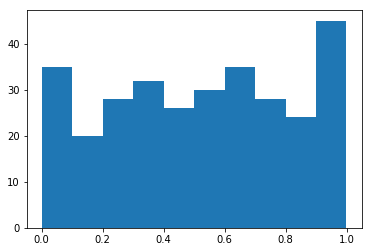

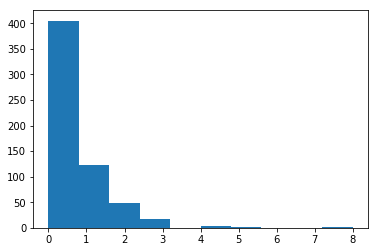

In [5]:
bins = np.load('./data/testing/acc_binary.npy')
freqs = np.load('./data/testing/acc_frequency.npy')
all_preds = np.load('./data/testing/preds_frequency.npy')
all_actuals = np.load('./data/testing/actuals_frequency.npy')
preds = np.reshape(all_preds, -1)
actuals = np.reshape(all_actuals, -1)
wrongs = []
for p, a in zip(preds, actuals):
    if int(np.round(p)) != int(a):
        wrongs.append(p)
print(np.shape(wrongs))
print(bit_to_freq(np.expand_dims(actuals[0:10], 1), 1024))
print(actuals[0:10])
plt.hist(wrongs)
plt.show()
hammings = []
for i in range(len(preds) // 10):
    hammings.append(np.sum([int(round(preds[i*10 + j])) != int(actuals[i*10 + j]) for j in range(10)]))
plt.hist(hammings)
plt.show()
# bit to freq is just inverse of binary representation for freq - use to calc hamming and confidence vs pred

In [38]:
# div and conquer freq detect - varying N, m

#N = 16384 
layer = 2  
layer2 = 5
#m = 30
TRIALS = 10 
TEST_BATCHES = 75
SNRdB = 8

#log = int(np.log2(N))

# Parameters
learning_rate = 0.005
num_iter = 17500 #80000
batch_size = log * 20
batch_size2 = 20



# Network Parameters
num_classes = 1

#snrs = [10, 8, 6, 4, 2, 0, -2]
#snrs = [4, 2, 0, -2]
Ns = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576]
Ms = [20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]


bin_accs = []
freq_accs = []
freq_accs2 = []
all_preds = []
all_actuals = []

#starts = [0]
#for i in range(1, log): # filling all the starting points
#    starts.append(starts[i-1] + np.random.randint(N // 4))

starts = [0] * 25 # if starting at 0 every resample
#indices = np.sort(np.random.choice(range(N), size=m, replace=False))

for N, m in zip(Ns, Ms):
    print('N:', N, ' m:', m)
    log = int(np.log2(N))
    batch_size = log * 20
    indices = np.sort(np.random.choice(range(N), size=m, replace=False))
    

    t_bins = []
    t_freqs = []
    t_freqs2 = []
    t_preds = []
    t_actuals = []
    
    training_size = 4999 #5999
    dict = {}
    dict2 = {}
    for i in range(training_size):
        if i % 500 == 0:
            print('gen training batch:', i)
        batch_x, batch_y, batch_freqs, batch_rands = make_batch_noisy_lohi(batch_size // log, SNRdB - 2, N, m, indices, starts) # i % 3
        batch_x_pair = np.zeros((batch_size, m, 2))
        batch_x_pair[:, :, 0] = np.real(batch_x)
        batch_x_pair[:, :, 1] = np.imag(batch_x)
        dict[i] = (batch_x_pair, batch_y, batch_rands)
        #dict2[i] = make_batch_parity([batch_x_pair[j] for j in range(0, len(batch_x_pair), log)], batch_freqs)
    
    for trial in range(TRIALS):
        print('TRIAL:', trial)
        # tf Graph input
        X = tf.placeholder("float", [None, m, 2])
        Y = tf.placeholder("float", [None, num_classes])
        Y2 = tf.placeholder("float", [None, num_classes])

        # weights for frequency classification
        weights = {i: tf.Variable(tf.random_normal([3, 2, 2])) for i in range(1, layer+1)} # increase out channels, less layers
        weights[0] = tf.Variable(tf.random_normal([5, 2, 2]))
        weights['out'] = tf.Variable(tf.random_normal([(m-4-(2*layer))*2, num_classes]))
        biases = {i: tf.Variable(tf.random_normal([2])) for i in range(layer+1)}
        biases['out'] = tf.Variable(tf.random_normal([num_classes]))


        def neural_net(x):
            layer_1 = tf.add(tf.nn.conv1d(x, weights[0], 1, 'VALID'), biases[0])
            hidden_1 = tf.nn.relu(layer_1)
            for i in range(1, layer+1):
                layer_1 = tf.add(tf.nn.conv1d(hidden_1, weights[i], 1, 'VALID'), biases[i]) # no padding
                hidden_1 = tf.nn.relu(layer_1) # try: elu, leaky
                ###hidden_1 = tf.layers.batch_normalization(hidden_1)
                ### instance normalize
            hidden_3 = tf.reshape(hidden_1, [batch_size, -1])
            out_layer = tf.matmul(hidden_3, weights['out']) + biases['out']
            return out_layer
        
        # weights for parity network
        weights2 = {i: tf.Variable(tf.random_normal([3, 2, 2])) for i in range(1, layer2+1)} # increase out channels, less layers
        weights2[0] = tf.Variable(tf.random_normal([5, 2, 2]))
        weights2['out'] = tf.Variable(tf.random_normal([(m-4-(2*layer2))*2, num_classes]))
        biases2 = {i: tf.Variable(tf.random_normal([2])) for i in range(layer2+1)}
        biases2['out'] = tf.Variable(tf.random_normal([num_classes]))


        def neural_net2(x):
            layer_1 = tf.add(tf.nn.conv1d(x, weights2[0], 1, 'VALID'), biases2[0])
            hidden_1 = tf.nn.relu(layer_1)
            for i in range(1, layer2+1):
                layer_1 = tf.add(tf.nn.conv1d(hidden_1, weights2[i], 1, 'VALID'), biases2[i]) # no padding
                hidden_1 = tf.nn.relu(layer_1) # try: elu, leaky
                ###hidden_1 = tf.layers.batch_normalization(hidden_1)
                ### instance normalize
            hidden_3 = tf.reshape(hidden_1, [batch_size2, -1])
            out_layer = tf.matmul(hidden_3, weights2['out']) + biases2['out']
            return out_layer


        test_dict = {}
        test_dict2 = {}
        for i in range(TEST_BATCHES):
            test_signals, test_freqs, freqs, test_rands = make_batch_noisy_lohi(batch_size // log, SNRdB, N, m, indices, starts)
            test_signals_pair = np.zeros((batch_size, m, 2))
            test_signals_pair[:, :, 0] = np.real(test_signals)
            test_signals_pair[:, :, 1] = np.imag(test_signals)
            test_dict[i] = (test_signals_pair, test_freqs, freqs, test_rands)
            #test_dict2[i] = make_batch_parity([test_signals_pair[j] for j in range(0, len(test_signals_pair), log)], freqs)



        # Construct model
        logits = neural_net(X)
        prediction = tf.nn.sigmoid(logits)
        losses, accuracies = [], []

        # Define loss and optimizer
        loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=Y))  

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op)

        # Evaluate model
        pred_class = tf.greater(prediction, 0.5)
        correct_pred = tf.equal(pred_class, tf.equal(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        # Construct model (parity)
        logits2 = neural_net2(X)
        prediction2 = tf.nn.sigmoid(logits2)
        losses2, accuracies2 = [], []

        # Define loss and optimizer
        loss_op2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits2, labels=Y2))  

        optimizer2 = tf.train.AdamOptimizer(learning_rate=0.00005)
        train_op2 = optimizer2.minimize(loss_op2)

        # Evaluate model
        pred_class2 = tf.greater(prediction2, 0.5)
        correct_pred2 = tf.equal(pred_class2, tf.equal(Y2, 1))
        accuracy2 = tf.reduce_mean(tf.cast(correct_pred2, tf.float32))

        # Initialize the variables (i.e. assign their default value)
        init = tf.global_variables_initializer()

        # Start training
        with tf.Session() as sess:

            # Run the initializer
            sess.run(init)
            print("Training Started")

            for step in range(1, num_iter + 1):
                batch_x_pair, batch_y, rands = dict[step % training_size]
                #batch_x_pair2, batch_y2 = dict2[step % training_size]

                # Run optimization op (backprop)
                sess.run(train_op, feed_dict={X: batch_x_pair, Y: batch_y})
                #sess.run(train_op2, feed_dict={X: batch_x_pair2, Y2: batch_y2})
                
                if step % 500 == 0:
                    # Calculate batch loss and accuracy
                    loss, acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: batch_x_pair,
                                                                         Y: batch_y})
                    #loss2, acc2, pred2 = sess.run([loss_op2, accuracy2, prediction2], feed_dict={X: batch_x_pair2,
                    #                                                     Y2: batch_y2})

                    accuracies.append(acc)
                    losses.append(loss)
                    print("Freq Iter " + str(step) + ", Minibatch Loss= " + \
                          "{:.4f}".format(loss) + ", Training Accuracy= " + \
                          "{:.3f}".format(acc))
                    #print("Pari Iter " + str(step) + ", Minibatch Loss= " + \
                    #      "{:.4f}".format(loss2) + ", Training Accuracy= " + \
                    #      "{:.3f}".format(acc2))
                    #print(pred2)
                    #print(batch_y2)
            print("Training Finished")
            preds = [sess.run(prediction, feed_dict={X: test_dict[i][0], Y: test_dict[i][1]}) for i in range(len(test_dict))]  
            nn_acc = [sess.run(accuracy, feed_dict={X: test_dict[i][0], Y: test_dict[i][1]}) for i in range(len(test_dict))]   
            print(nn_acc)
        t_preds.append(preds)
        t_actuals.append([test_dict[i][1] for i in range(len(test_dict))])

        t_bins.append(np.median(nn_acc))
        preds = np.round(preds)
        corr = []
        corr2 = []
        for a in range(len(test_dict)):
            fs = []
            fs2 = []
            for k in range(len(preds[a]) // log):
                    ##fs2.append(bit_to_freq(preds[a][k * log : (k+1) * log], N))
                    fs2.append(convert_bits(preds[a][k * log : (k+1) * log]))
                    #fs2.append(test_all_1bit(preds[a][k * log : (k+1) * log], N, m, test_dict[a][0][k * log]))
                    fs.append(test_all_1bit_random(preds[a][k * log : (k+1) * log], N, m, test_dict[a][3][k], indices))
            corr.extend([fs[i] == test_dict[a][2][i] % N for i in range(len(fs))])
            corr2.extend([fs2[i] == test_dict[a][2][i] % N for i in range(len(fs2))])
        t_freqs.append(np.sum(corr) / (len(fs) * len(test_dict)))
        t_freqs2.append(np.sum(corr2) / (len(fs) * len(test_dict)))
        print('random:', t_freqs[-1])
        print('single:', np.sum(corr2) / (len(fs2) * len(test_dict)))
        
    bin_accs.append(max(t_bins))
    freq_accs.append(max(t_freqs))
    freq_accs2.append(max(t_freqs2))
    all_preds.append(t_preds[np.argmax(t_freqs)])
    all_actuals.append(t_actuals[np.argmax(t_freqs)])
    print('best bin classifier acc:', bin_accs[-1])
    print('best freq detection acc:', freq_accs[-1])
    print('best freq2 detection acc:', freq_accs2[-1])
    
np.save('./data/freq_new_network/N_testing/Ns', Ns)   
np.save('./data/freq_new_network/N_testing/acc_binary_8db_random', bin_accs)
np.save('./data/freq_new_network/N_testing/acc_frequency_8db_random', freq_accs)
np.save('./data/freq_new_network/N_testing/acc_frequency_8db_single', freq_accs2)
##np.save('./data/freq_new_network/preds_frequency', all_preds)
##np.save('./data/freq_new_network/actuals_frequency', all_actuals)




N: 1024  m: 20
gen training batch: 0
gen training batch: 500
gen training batch: 1000
gen training batch: 1500
gen training batch: 2000
gen training batch: 2500
gen training batch: 3000
gen training batch: 3500
gen training batch: 4000
gen training batch: 4500
TRIAL: 0
Training Started
Freq Iter 500, Minibatch Loss= 0.3216, Training Accuracy= 0.870
Freq Iter 1000, Minibatch Loss= 0.0602, Training Accuracy= 0.995
Freq Iter 1500, Minibatch Loss= 0.0448, Training Accuracy= 0.985
Freq Iter 2000, Minibatch Loss= 0.0570, Training Accuracy= 0.975
Freq Iter 2500, Minibatch Loss= 0.0154, Training Accuracy= 1.000
Freq Iter 3000, Minibatch Loss= 0.0111, Training Accuracy= 1.000
Freq Iter 3500, Minibatch Loss= 0.0309, Training Accuracy= 0.985
Freq Iter 4000, Minibatch Loss= 0.0594, Training Accuracy= 0.980
Freq Iter 4500, Minibatch Loss= 0.0508, Training Accuracy= 0.990
Freq Iter 5000, Minibatch Loss= 0.0410, Training Accuracy= 0.985
Freq Iter 5500, Minibatch Loss= 0.0286, Training Accuracy= 0.990

Freq Iter 15500, Minibatch Loss= 0.0040, Training Accuracy= 1.000
Freq Iter 16000, Minibatch Loss= 0.0475, Training Accuracy= 0.990
Freq Iter 16500, Minibatch Loss= 0.0316, Training Accuracy= 0.990
Freq Iter 17000, Minibatch Loss= 0.0018, Training Accuracy= 1.000
Freq Iter 17500, Minibatch Loss= 0.0038, Training Accuracy= 1.000
Training Finished
[1.0, 0.975, 0.99499995, 1.0, 0.96500003, 0.9899999, 0.99, 0.995, 0.9999999, 0.9999999, 1.0, 1.0, 0.97, 0.995, 1.0, 0.99, 1.0, 0.9949999, 0.995, 0.985, 1.0, 1.0, 1.0, 0.99999994, 0.99999994, 0.9999999, 0.985, 1.0, 1.0, 0.99, 1.0, 0.995, 1.0, 0.9999999, 0.99999994, 1.0, 0.995, 0.995, 0.9849999, 1.0, 0.99, 0.995, 0.99, 1.0, 0.985, 1.0, 0.985, 1.0, 0.995, 0.9799999, 0.9999999, 0.99999994, 0.99, 1.0, 0.99, 0.9949999, 0.9949999, 0.9799999, 0.9999999, 0.985, 0.98, 0.99, 0.99, 1.0, 0.99999994, 0.995, 0.995, 0.9849999, 0.9849999, 0.99, 1.0, 1.0, 0.985, 0.98, 1.0]
random: 0.9846666666666667
single: 0.9553333333333334
TRIAL: 3
Training Started
Freq Iter 

Freq Iter 9000, Minibatch Loss= 0.0033, Training Accuracy= 1.000
Freq Iter 9500, Minibatch Loss= 0.0039, Training Accuracy= 1.000
Freq Iter 10000, Minibatch Loss= 0.0066, Training Accuracy= 1.000
Freq Iter 10500, Minibatch Loss= 0.0032, Training Accuracy= 1.000
Freq Iter 11000, Minibatch Loss= 0.0034, Training Accuracy= 1.000
Freq Iter 11500, Minibatch Loss= 0.0037, Training Accuracy= 1.000
Freq Iter 12000, Minibatch Loss= 0.0019, Training Accuracy= 1.000
Freq Iter 12500, Minibatch Loss= 0.0017, Training Accuracy= 1.000
Freq Iter 13000, Minibatch Loss= 0.0041, Training Accuracy= 1.000
Freq Iter 13500, Minibatch Loss= 0.0028, Training Accuracy= 1.000
Freq Iter 14000, Minibatch Loss= 0.0029, Training Accuracy= 1.000
Freq Iter 14500, Minibatch Loss= 0.0097, Training Accuracy= 0.995
Freq Iter 15000, Minibatch Loss= 0.0255, Training Accuracy= 0.990
Freq Iter 15500, Minibatch Loss= 0.0048, Training Accuracy= 1.000
Freq Iter 16000, Minibatch Loss= 0.0382, Training Accuracy= 0.990
Freq Iter 16

Training Started
Freq Iter 500, Minibatch Loss= 0.6626, Training Accuracy= 0.605
Freq Iter 1000, Minibatch Loss= 0.0528, Training Accuracy= 1.000
Freq Iter 1500, Minibatch Loss= 0.0218, Training Accuracy= 1.000
Freq Iter 2000, Minibatch Loss= 0.0305, Training Accuracy= 0.990
Freq Iter 2500, Minibatch Loss= 0.0092, Training Accuracy= 1.000
Freq Iter 3000, Minibatch Loss= 0.0107, Training Accuracy= 1.000
Freq Iter 3500, Minibatch Loss= 0.0242, Training Accuracy= 0.990
Freq Iter 4000, Minibatch Loss= 0.0555, Training Accuracy= 0.980
Freq Iter 4500, Minibatch Loss= 0.0390, Training Accuracy= 0.995
Freq Iter 5000, Minibatch Loss= 0.0447, Training Accuracy= 0.990
Freq Iter 5500, Minibatch Loss= 0.0397, Training Accuracy= 0.990
Freq Iter 6000, Minibatch Loss= 0.0018, Training Accuracy= 1.000
Freq Iter 6500, Minibatch Loss= 0.0239, Training Accuracy= 0.995
Freq Iter 7000, Minibatch Loss= 0.0041, Training Accuracy= 1.000
Freq Iter 7500, Minibatch Loss= 0.0057, Training Accuracy= 0.995
Freq Iter

Freq Iter 15000, Minibatch Loss= 0.0175, Training Accuracy= 0.991
Freq Iter 15500, Minibatch Loss= 0.0567, Training Accuracy= 0.986
Freq Iter 16000, Minibatch Loss= 0.0298, Training Accuracy= 0.991
Freq Iter 16500, Minibatch Loss= 0.0399, Training Accuracy= 0.991
Freq Iter 17000, Minibatch Loss= 0.0083, Training Accuracy= 0.995
Freq Iter 17500, Minibatch Loss= 0.0174, Training Accuracy= 0.995
Training Finished
[0.99090904, 0.99999994, 0.99999994, 0.99545443, 0.99545443, 0.99999994, 0.9954545, 0.99090904, 0.99999994, 0.99999994, 0.98636353, 0.9863636, 0.99999994, 0.9772726, 0.98636353, 0.99999994, 0.99999994, 0.9954545, 0.99545443, 0.9954545, 0.99999994, 0.99545443, 0.99999994, 0.99999994, 0.9954545, 0.9863636, 0.9954545, 0.99545443, 0.99999994, 0.99090904, 0.99545443, 0.98636353, 0.99545443, 0.99999994, 0.9954545, 0.9954545, 0.9954545, 0.99999994, 0.9954545, 0.99090904, 0.99090904, 0.990909, 0.9954545, 0.99999994, 0.99090904, 0.99999994, 0.99999994, 0.98636353, 0.9954545, 0.9863636, 0.

Freq Iter 3500, Minibatch Loss= 0.0391, Training Accuracy= 0.991
Freq Iter 4000, Minibatch Loss= 0.0102, Training Accuracy= 1.000
Freq Iter 4500, Minibatch Loss= 0.0275, Training Accuracy= 0.986
Freq Iter 5000, Minibatch Loss= 0.0405, Training Accuracy= 0.977
Freq Iter 5500, Minibatch Loss= 0.0135, Training Accuracy= 0.995
Freq Iter 6000, Minibatch Loss= 0.0136, Training Accuracy= 0.995
Freq Iter 6500, Minibatch Loss= 0.0248, Training Accuracy= 0.991
Freq Iter 7000, Minibatch Loss= 0.0082, Training Accuracy= 1.000
Freq Iter 7500, Minibatch Loss= 0.0153, Training Accuracy= 0.995
Freq Iter 8000, Minibatch Loss= 0.0164, Training Accuracy= 0.991
Freq Iter 8500, Minibatch Loss= 0.0152, Training Accuracy= 0.991
Freq Iter 9000, Minibatch Loss= 0.0249, Training Accuracy= 0.995
Freq Iter 9500, Minibatch Loss= 0.0135, Training Accuracy= 0.995
Freq Iter 10000, Minibatch Loss= 0.0100, Training Accuracy= 0.995
Freq Iter 10500, Minibatch Loss= 0.0164, Training Accuracy= 0.991
Freq Iter 11000, Miniba

Freq Iter 16500, Minibatch Loss= 0.0398, Training Accuracy= 0.986
Freq Iter 17000, Minibatch Loss= 0.0037, Training Accuracy= 1.000
Freq Iter 17500, Minibatch Loss= 0.0151, Training Accuracy= 0.995
Training Finished
[0.99999994, 0.9954545, 0.9954545, 0.9818181, 0.9999999, 0.99999994, 0.99090904, 0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99545443, 0.99545443, 0.9954545, 0.9954545, 0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.9954545, 0.99999994, 0.99999994, 0.99999994, 0.98636353, 0.9954545, 0.99999994, 0.99090904, 0.99090904, 0.9954545, 0.9954545, 0.99545443, 0.99999994, 0.99999994, 0.99999994, 0.9954545, 0.990909, 0.98636353, 0.99545443, 0.990909, 0.99999994, 0.99999994, 0.99999994, 0.9954545, 0.99999994, 0.98181814, 0.9954545, 0.99999994, 0.99999994, 0.99545443, 0.990909, 0.9954545, 0.9999999, 0.99999994, 0.9818181, 0.99090904, 0.99999994, 0.9772727, 0.9954545, 0.99999994, 0.99090904, 0.99999994, 0.99999994, 0.9954545, 0.99999994, 0.99090904, 0.9954545, 0.995

Freq Iter 5000, Minibatch Loss= 0.0506, Training Accuracy= 0.986
Freq Iter 5500, Minibatch Loss= 0.0134, Training Accuracy= 0.995
Freq Iter 6000, Minibatch Loss= 0.0146, Training Accuracy= 0.995
Freq Iter 6500, Minibatch Loss= 0.0186, Training Accuracy= 0.991
Freq Iter 7000, Minibatch Loss= 0.0060, Training Accuracy= 1.000
Freq Iter 7500, Minibatch Loss= 0.0409, Training Accuracy= 0.986
Freq Iter 8000, Minibatch Loss= 0.0262, Training Accuracy= 0.991
Freq Iter 8500, Minibatch Loss= 0.0144, Training Accuracy= 0.991
Freq Iter 9000, Minibatch Loss= 0.0743, Training Accuracy= 0.977
Freq Iter 9500, Minibatch Loss= 0.0106, Training Accuracy= 1.000
Freq Iter 10000, Minibatch Loss= 0.0141, Training Accuracy= 0.995
Freq Iter 10500, Minibatch Loss= 0.0143, Training Accuracy= 0.995
Freq Iter 11000, Minibatch Loss= 0.0075, Training Accuracy= 1.000
Freq Iter 11500, Minibatch Loss= 0.0063, Training Accuracy= 1.000
Freq Iter 12000, Minibatch Loss= 0.0118, Training Accuracy= 1.000
Freq Iter 12500, Min

Freq Iter 15500, Minibatch Loss= 0.0017, Training Accuracy= 1.000
Freq Iter 16000, Minibatch Loss= 0.0011, Training Accuracy= 1.000
Freq Iter 16500, Minibatch Loss= 0.0031, Training Accuracy= 1.000
Freq Iter 17000, Minibatch Loss= 0.0052, Training Accuracy= 1.000
Freq Iter 17500, Minibatch Loss= 0.0133, Training Accuracy= 0.996
Training Finished
[1.0, 1.0, 0.99583334, 0.99583334, 0.9958333, 0.99583334, 0.9916667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99583334, 0.98333335, 1.0, 0.975, 1.0, 0.99583334, 1.0, 0.9875, 0.9916667, 1.0, 0.9958333, 1.0, 1.0, 0.9875, 1.0, 0.9958333, 0.9875, 1.0, 0.99583334, 0.98749995, 1.0, 1.0, 1.0, 0.9791667, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9833333, 1.0, 1.0, 1.0, 0.9958333, 1.0, 0.99583334, 0.9916666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9916667, 0.9916667, 0.99583334, 0.99583334, 1.0, 0.99583334, 0.9958333, 1.0, 1.0, 0.9958333, 0.9916667, 1.0]
random: 0.9906666666666667
single: 0.976
TRIAL: 1
Training Started
Freq Iter 500, Minibatch Loss=

Freq Iter 10000, Minibatch Loss= 0.0419, Training Accuracy= 0.992
Freq Iter 10500, Minibatch Loss= 0.0069, Training Accuracy= 0.996
Freq Iter 11000, Minibatch Loss= 0.0023, Training Accuracy= 1.000
Freq Iter 11500, Minibatch Loss= 0.0040, Training Accuracy= 1.000
Freq Iter 12000, Minibatch Loss= 0.0031, Training Accuracy= 1.000
Freq Iter 12500, Minibatch Loss= 0.0168, Training Accuracy= 0.996
Freq Iter 13000, Minibatch Loss= 0.0049, Training Accuracy= 1.000
Freq Iter 13500, Minibatch Loss= 0.0023, Training Accuracy= 1.000
Freq Iter 14000, Minibatch Loss= 0.0086, Training Accuracy= 1.000
Freq Iter 14500, Minibatch Loss= 0.0479, Training Accuracy= 0.988
Freq Iter 15000, Minibatch Loss= 0.0143, Training Accuracy= 0.996
Freq Iter 15500, Minibatch Loss= 0.0037, Training Accuracy= 1.000
Freq Iter 16000, Minibatch Loss= 0.0136, Training Accuracy= 0.996
Freq Iter 16500, Minibatch Loss= 0.0060, Training Accuracy= 1.000
Freq Iter 17000, Minibatch Loss= 0.0031, Training Accuracy= 1.000
Freq Iter 

Freq Iter 4000, Minibatch Loss= 0.0181, Training Accuracy= 0.992
Freq Iter 4500, Minibatch Loss= 0.0066, Training Accuracy= 1.000
Freq Iter 5000, Minibatch Loss= 0.0153, Training Accuracy= 0.996
Freq Iter 5500, Minibatch Loss= 0.0044, Training Accuracy= 1.000
Freq Iter 6000, Minibatch Loss= 0.0247, Training Accuracy= 0.996
Freq Iter 6500, Minibatch Loss= 0.0036, Training Accuracy= 1.000
Freq Iter 7000, Minibatch Loss= 0.0330, Training Accuracy= 0.996
Freq Iter 7500, Minibatch Loss= 0.0132, Training Accuracy= 0.996
Freq Iter 8000, Minibatch Loss= 0.0241, Training Accuracy= 0.996
Freq Iter 8500, Minibatch Loss= 0.0210, Training Accuracy= 0.996
Freq Iter 9000, Minibatch Loss= 0.0075, Training Accuracy= 1.000
Freq Iter 9500, Minibatch Loss= 0.0038, Training Accuracy= 1.000
Freq Iter 10000, Minibatch Loss= 0.0377, Training Accuracy= 0.992
Freq Iter 10500, Minibatch Loss= 0.0094, Training Accuracy= 0.996
Freq Iter 11000, Minibatch Loss= 0.0027, Training Accuracy= 1.000
Freq Iter 11500, Minib

random: 0.9933333333333333
single: 0.9606666666666667
TRIAL: 9
Training Started
Freq Iter 500, Minibatch Loss= 0.3216, Training Accuracy= 0.917
Freq Iter 1000, Minibatch Loss= 0.0365, Training Accuracy= 0.996
Freq Iter 1500, Minibatch Loss= 0.0243, Training Accuracy= 0.996
Freq Iter 2000, Minibatch Loss= 0.0584, Training Accuracy= 0.983
Freq Iter 2500, Minibatch Loss= 0.0127, Training Accuracy= 1.000
Freq Iter 3000, Minibatch Loss= 0.0051, Training Accuracy= 1.000
Freq Iter 3500, Minibatch Loss= 0.0152, Training Accuracy= 0.992
Freq Iter 4000, Minibatch Loss= 0.0065, Training Accuracy= 1.000
Freq Iter 4500, Minibatch Loss= 0.0111, Training Accuracy= 0.996
Freq Iter 5000, Minibatch Loss= 0.0072, Training Accuracy= 0.996
Freq Iter 5500, Minibatch Loss= 0.0046, Training Accuracy= 1.000
Freq Iter 6000, Minibatch Loss= 0.0042, Training Accuracy= 1.000
Freq Iter 6500, Minibatch Loss= 0.0059, Training Accuracy= 1.000
Freq Iter 7000, Minibatch Loss= 0.0455, Training Accuracy= 0.992
Freq Iter 7

Freq Iter 13500, Minibatch Loss= 0.0284, Training Accuracy= 0.992
Freq Iter 14000, Minibatch Loss= 0.0179, Training Accuracy= 0.988
Freq Iter 14500, Minibatch Loss= 0.0045, Training Accuracy= 1.000
Freq Iter 15000, Minibatch Loss= 0.0042, Training Accuracy= 1.000
Freq Iter 15500, Minibatch Loss= 0.0021, Training Accuracy= 1.000
Freq Iter 16000, Minibatch Loss= 0.0013, Training Accuracy= 1.000
Freq Iter 16500, Minibatch Loss= 0.0063, Training Accuracy= 0.996
Freq Iter 17000, Minibatch Loss= 0.0128, Training Accuracy= 0.992
Freq Iter 17500, Minibatch Loss= 0.0020, Training Accuracy= 1.000
Training Finished
[0.98846155, 1.0, 1.0, 1.0, 0.99615383, 1.0, 1.0, 0.9923077, 0.9846153, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99615383, 1.0, 0.99230766, 0.9884615, 1.0, 0.99615383, 0.98846155, 1.0, 1.0, 0.9884615, 0.99615383, 1.0, 0.98846155, 0.99615383, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99615383, 0.99615383, 1.0, 0.99230766, 0.99230766, 1.0, 1.0, 0.99615383, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

Freq Iter 9000, Minibatch Loss= 0.0031, Training Accuracy= 1.000
Freq Iter 9500, Minibatch Loss= 0.0033, Training Accuracy= 1.000
Freq Iter 10000, Minibatch Loss= 0.0637, Training Accuracy= 0.988
Freq Iter 10500, Minibatch Loss= 0.0050, Training Accuracy= 1.000
Freq Iter 11000, Minibatch Loss= 0.0184, Training Accuracy= 0.992
Freq Iter 11500, Minibatch Loss= 0.0694, Training Accuracy= 0.985
Freq Iter 12000, Minibatch Loss= 0.0861, Training Accuracy= 0.981
Freq Iter 12500, Minibatch Loss= 0.0039, Training Accuracy= 1.000
Freq Iter 13000, Minibatch Loss= 0.0038, Training Accuracy= 1.000
Freq Iter 13500, Minibatch Loss= 0.0412, Training Accuracy= 0.988
Freq Iter 14000, Minibatch Loss= 0.0384, Training Accuracy= 0.992
Freq Iter 14500, Minibatch Loss= 0.0030, Training Accuracy= 1.000
Freq Iter 15000, Minibatch Loss= 0.0111, Training Accuracy= 1.000
Freq Iter 15500, Minibatch Loss= 0.0036, Training Accuracy= 1.000
Freq Iter 16000, Minibatch Loss= 0.0017, Training Accuracy= 1.000
Freq Iter 16

Freq Iter 2000, Minibatch Loss= 0.0102, Training Accuracy= 0.996
Freq Iter 2500, Minibatch Loss= 0.0607, Training Accuracy= 0.973
Freq Iter 3000, Minibatch Loss= 0.0132, Training Accuracy= 0.996
Freq Iter 3500, Minibatch Loss= 0.0263, Training Accuracy= 0.996
Freq Iter 4000, Minibatch Loss= 0.0028, Training Accuracy= 1.000
Freq Iter 4500, Minibatch Loss= 0.0035, Training Accuracy= 1.000
Freq Iter 5000, Minibatch Loss= 0.0244, Training Accuracy= 0.992
Freq Iter 5500, Minibatch Loss= 0.0113, Training Accuracy= 0.996
Freq Iter 6000, Minibatch Loss= 0.0173, Training Accuracy= 0.992
Freq Iter 6500, Minibatch Loss= 0.0136, Training Accuracy= 0.996
Freq Iter 7000, Minibatch Loss= 0.0069, Training Accuracy= 1.000
Freq Iter 7500, Minibatch Loss= 0.0518, Training Accuracy= 0.988
Freq Iter 8000, Minibatch Loss= 0.0065, Training Accuracy= 1.000
Freq Iter 8500, Minibatch Loss= 0.0235, Training Accuracy= 0.992
Freq Iter 9000, Minibatch Loss= 0.0024, Training Accuracy= 1.000
Freq Iter 9500, Minibatch

random: 0.988
single: 0.9546666666666667
best bin classifier acc: 1.0
best freq detection acc: 0.9933333333333333
best freq2 detection acc: 0.9813333333333333
N: 16384  m: 28
gen training batch: 0
gen training batch: 500
gen training batch: 1000
gen training batch: 1500


KeyboardInterrupt: 